In [1]:
# These two lines allow for the notebook to automatically update to use the most
# up-to-date versions of the code being imported
%load_ext autoreload
%autoreload 2

import control as ct
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyphotonicsims.control_systems.control_core import *
from pyphotonicsims.control_systems.calculate_laser_noise import *
from pyphotonicsims.laser_dynamics.semiconductor_laser import *

from scipy.integrate import odeint, RK45, solve_ivp

# plt.style.available
%matplotlib inline
plt.style.use('science')
plt.rcParams['figure.figsize'] = [4,3]
plt.rcParams["figure.autolayout"] = True

## This is a model for hybrid external cavity laser reported in the following paper
#### Fan, Youwen, et al. "Hybrid integrated InP-Si 3 N 4 diode laser with a 40-Hz intrinsic linewidth." Optics express 28.15 (2020): 21713-21728. 
#### Laser metrics caculation: cavity Q, threshold $I_{th}$, efficiency $\eta$, ST linewidth $\nu_{ST}$

In [2]:
laser = LaserModel('hybrid')

-----------------REPORT------------------
Cavity Q:      2.6e+05
Active loss:   39.7 MHz
Passive loss:  205.7 MHz
Cavity loss:   245.4 MHz
Mirror loss:   490.8 MHz
g_th:          1157.4 cm^(-1)
N_th:          3.06e18 cm^(-3)
I_th:          81.7 mA
eta_d:         66.7 %
eta:           53.3 %
ST linewidth:  1.1e+02 Hz


#### PI sweep from 0 mA to $10\times I_{th}$, showing thresholding and linewidth narrowing behaviors

c:\users\lkk12\documents\code\pyphotonicsims\pyphotonicsims\laser_dynamics\semiconductor_laser.py:102: RuntimeWarning: invalid value encountered in log
  g = self.g0 / (1 + self.eps * Np) * (np.log(Ne + self.N_s) - np.log(self.N_tr + self.N_s))


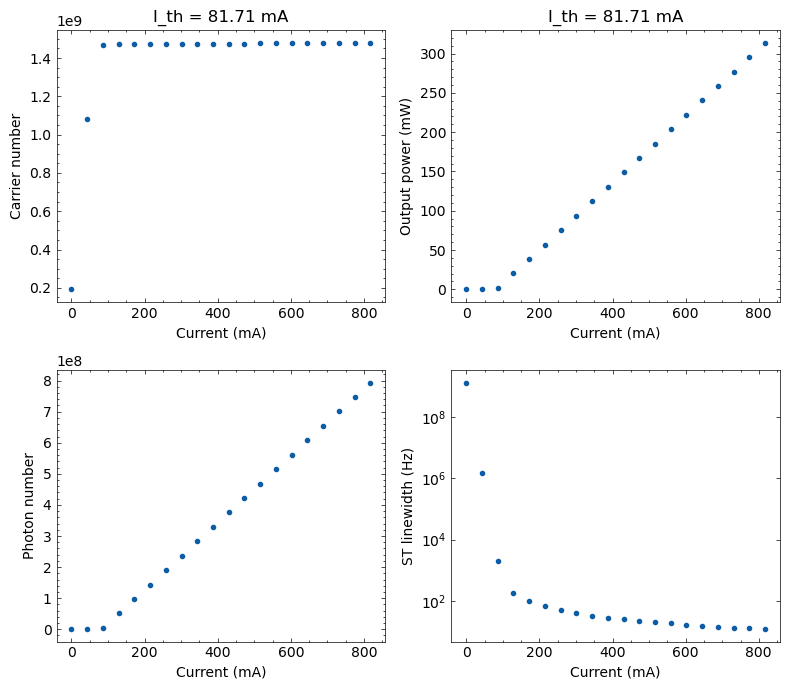

In [3]:
Ix = np.linspace(0,10*laser.I_th,20)
laser.PI_visulization(Ix,plotindensity=False)

#### Time-domain transient visualization of laser dynamics

c:\users\lkk12\documents\code\pyphotonicsims\pyphotonicsims\laser_dynamics\semiconductor_laser.py:102: RuntimeWarning: invalid value encountered in log
  g = self.g0 / (1 + self.eps * Np) * (np.log(Ne + self.N_s) - np.log(self.N_tr + self.N_s))


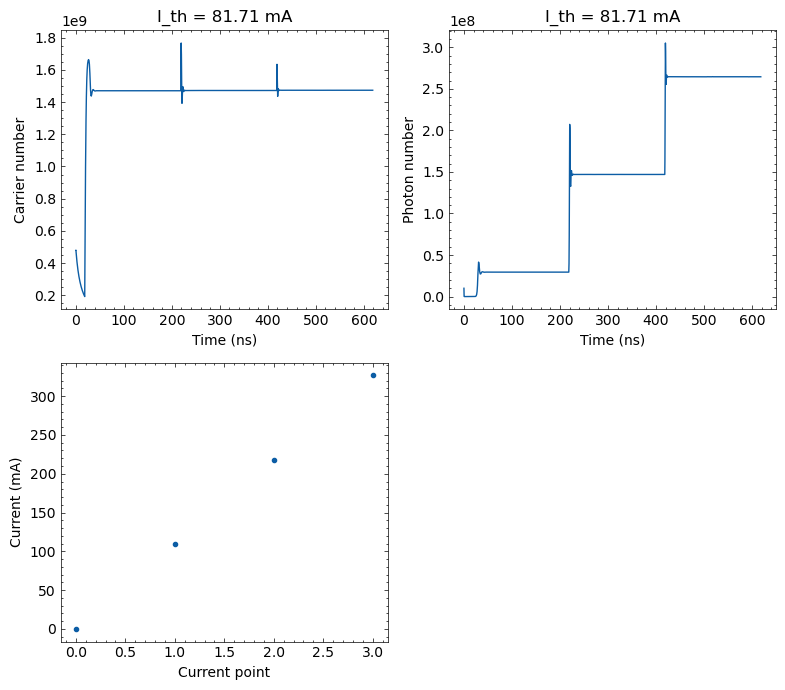

In [4]:
Ix = np.linspace(0,4*laser.I_th,4)
laser.transient_visulization(Ix,plotindensity=False)

#### Laser current modulation frequency response, in terms of carrier density, photon density and output power 

Text(0, 0.5, 'dP/dI (mW/mA)')

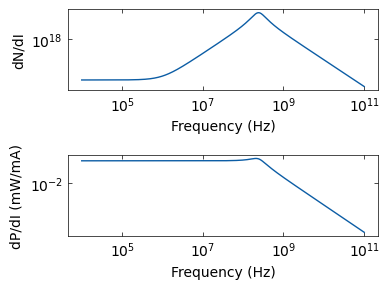

In [5]:
n1,s1,p1,H,freqx = laser.freqresp_current_mod(laser.I_th*2,freq1 = 1e4,freq2 = 1e11)
plt.subplot(211)
plt.loglog(freqx,abs(n1))
plt.xlabel('Frequency (Hz)')
plt.ylabel('dN/dI')
plt.subplot(212)
plt.loglog(freqx,abs(p1))
plt.xlabel('Frequency (Hz)')
plt.ylabel('dP/dI (mW/mA)')

# Laser metrics $N_{th}$, $g_{th}$, $Q$, $I_{th}$, $\nu_{ST}$ vs cavity extention length $L$

Text(0, 0.5, '$\\nu_{ST}$ (Hz)')

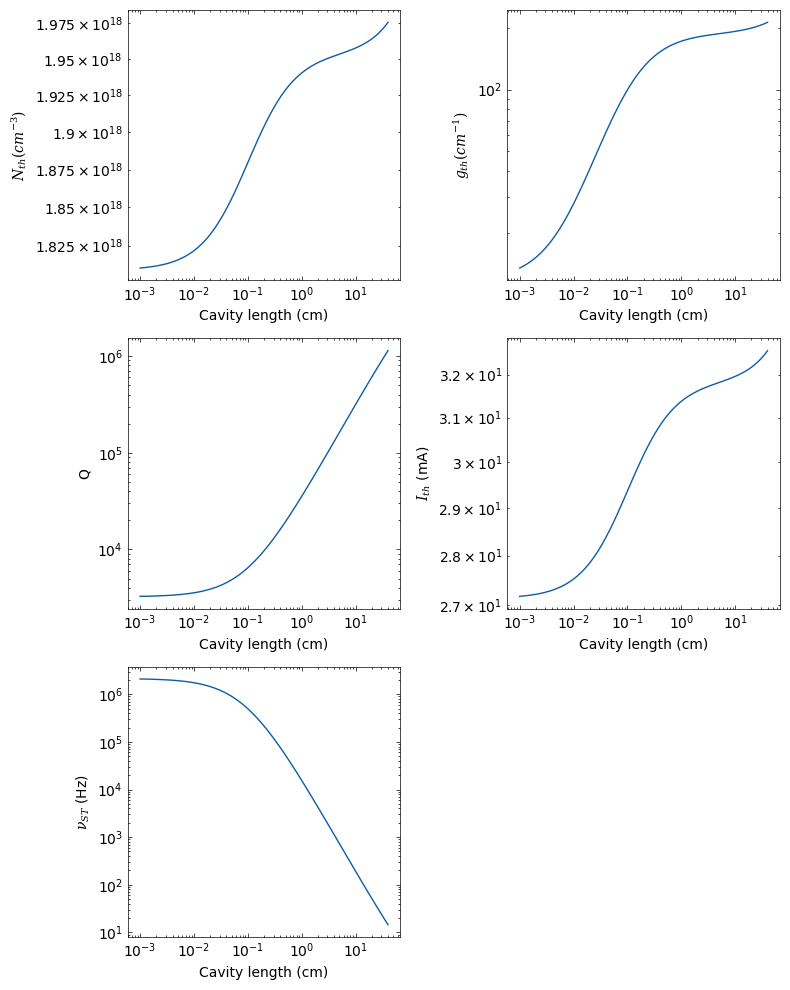

In [6]:
laser.a_in_p = 0.01 / 4.34
Lpx = np.logspace(-3,2,100)
N_th_x = np.zeros(len(Lpx))
g_th_x = np.zeros(len(Lpx))
I_th_x = np.zeros(len(Lpx))
Q_x = np.zeros(len(Lpx))
vST_x = np.zeros(len(Lpx))
for ii in range(len(Lpx)):
    laser.Lp = Lpx[ii]
    laser.Veff_p = laser.Lp * 2e-8
    laser.Veff = laser.Veff_a + laser.Veff_p
    laser.Gamma = laser.V / laser.Veff
    laser.threshold_calc(ifprint=False,optimal_a_m=True)
    N_th_x[ii] = laser.N_th
    g_th_x[ii] = laser.g_th
    I_th_x[ii] = laser.I_th
    Q_x[ii] = laser.Q
    vST_x[ii] = laser.vST_2Ith
    
plt.figure(figsize=(8,10))
plt.subplot(321)
plt.loglog(Lpx,N_th_x)
plt.xlabel('Cavity length (cm)')
plt.ylabel(r'$N_{th} (cm^{-3})$')
plt.subplot(322)
plt.loglog(Lpx,g_th_x)
plt.xlabel('Cavity length (cm)')
plt.ylabel(r'$g_{th} (cm^{-1})$')
plt.subplot(323)
plt.loglog(Lpx,Q_x)
plt.xlabel('Cavity length (cm)')
plt.ylabel('Q')
plt.subplot(324)
plt.loglog(Lpx,I_th_x*1e3)
plt.xlabel('Cavity length (cm)')
plt.ylabel(r'$I_{th}$' + ' (mA)')
plt.subplot(325)
plt.loglog(Lpx,vST_x)
plt.xlabel('Cavity length (cm)')
plt.ylabel(r'$\nu_{ST}$' +' (Hz)')